# Anomaly Detection using LSTM Encoder-Decoder.

This is the third of four notebooks used in defining and training an encoder-decoder LSTM architecture for anomaly detection. Each of the following four steps are completed in an individual notebook:

- __Preprocess__: Preprocess raw ICEWS data into time series for training and evaluating a model.
- __Train__: Create and train a model with pre-processed and cleaned data.
- __Threshold calculation__: Use the residuals from a validation set to determine an anomaly detection threshold.
- __Inference__: Run anomaly detection on data from various countries to assess performance.

In [1]:
import sys
sys.path.append('..')

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import sklearn.preprocessing as pre

import joblib
from util import data, preprocess, icews, metrics
from models import networks, spot

sns.set()
plt.rcParams['figure.figsize'] = (10, 5)
np.random.seed(123)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load trained model for inference on validation set
Using the trained autoencoder, we will perform inference on the entire validation set to collect residuals. The validation set is used for this purpose because it will generalize the idea of error best to unseen data. 

In [2]:
# Define window size and embedding multiplier
factor = 8
window = 7

# Load dataset
valid_data = joblib.load(f'data/icews_ml/{window}day_validate.joblib')

# Get number of variables, and embedding size
n_features = 5 
emb_size = int(n_features * window * factor)

# Apply difference transform in parallel to entire dataset:
loader = DataLoader(valid_data, batch_size=len(valid_data))
valid_data = iter(loader).next().float().to(device)

In [3]:
model = networks.LSTMEncoderDecoder(n_features, emb_size)

model.load_state_dict(
    torch.load(
        f'data/models/ae_lstm_mse_sum_{window}d_{factor}f.pt',
        map_location=torch.device(device)
    )
)

<All keys matched successfully>

In [4]:
model = model.to(device)
model

LSTMEncoderDecoder(
  (encoder): SeqEncoderLSTM(
    (lstm): LSTM(5, 280, batch_first=True)
  )
  (decoder): SeqDecoderLSTM(
    (cell): LSTMCell(5, 280)
    (dense): Linear(in_features=280, out_features=5, bias=True)
  )
)

## Visualize Reconstruction
Just for fun, let's get a visual of how our model performed on a 7 day period pulled from the validation data:

In [5]:
# Get a random sample for displaying reconstruction results
x = valid_data[20].unsqueeze(0).float()
x.shape, valid_data.shape

(torch.Size([1, 7, 5]), torch.Size([971, 7, 5]))

In [6]:
transform = preprocess.Difference()

x_hat = model(x)
x_hat = transform.inverse(x_hat.squeeze(0))
x = transform.inverse(x.squeeze(0))

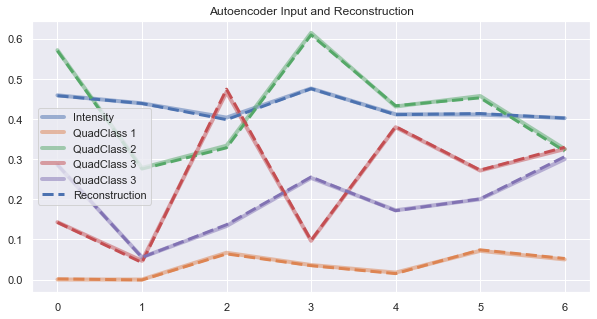

In [7]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colors = colors[:n_features]

p = plt.plot(x.cpu().squeeze(), '-', linewidth=4, label='Input', alpha=0.5,);
q = plt.plot(x_hat.detach().cpu().squeeze(), '--', linewidth=3, label='Reconstructed');

for l1, l2, c in zip(p, q, colors):
    l1.set_color(c)
    l2.set_color(c)
    
plt.legend(['Intensity', 'QuadClass 1', 'QuadClass 2', 'QuadClass 3', 'QuadClass 3', 'Reconstruction'])
plt.title('Autoencoder Input and Reconstruction');

## Calculate loss
Now, we will calculate loss on the entire dataset.

In [8]:
criterion = nn.L1Loss(reduction='none')
loss = torch.tensor([]).to(device)

for seq in valid_data:
    seq = seq.unsqueeze(0)
    with torch.no_grad():
        seq_hat = model(seq)
        seq_loss = criterion(seq_hat, seq)
        loss = torch.cat((loss, seq_loss))   

# concatenate loss of each subsequence.
loss = loss.view(-1, n_features).cpu().numpy()

## Anomaly score method
We will use the following formula for calculating anomaly scores $\mathbf{a}$:

$$a^{(i)} = \sqrt{(\mathbf{e}^{(i)} - \mathbf{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{e}^{(i)} - \mathbf{\mu})}$$

where $\mathbf{\Sigma}$ and $\mu$ are the maximum likelihood estimates of the population covariance and mean respectively. $\mathbf{e}^{(i)}$ is the vector containing the reconstruction error from each point in a sub-sequence. This method of scoring is robust against non-spherical distributions. 

In [9]:
# Get and save mu and sigma for scoring anomaly detection
md = metrics.MahalaDistance()
parameters = md.fit(loss)
joblib.dump(parameters, f'data/models/mu_sigma_{window}d_{factor}f.joblib')

['data/models/mu_sigma_7d_8f.joblib']

In [10]:
scores = md.measure(loss)

## Calculating a threshold:
We will calculate an emperical cumulative density function for the collected anomaly scores. The score below which there is a 99 percent chance of occurance will be our threshold.

In [11]:
from statsmodels.distributions.empirical_distribution import ECDF

cdf = ECDF(np.sort(scores))
thresh = next(x for x in scores if cdf(x) > 0.99)
joblib.dump(thresh, f'data/models/AD_threshold_{window}d_{factor}f.joblib')

['data/models/AD_threshold_7d_8f.joblib']

## Visualizing the results

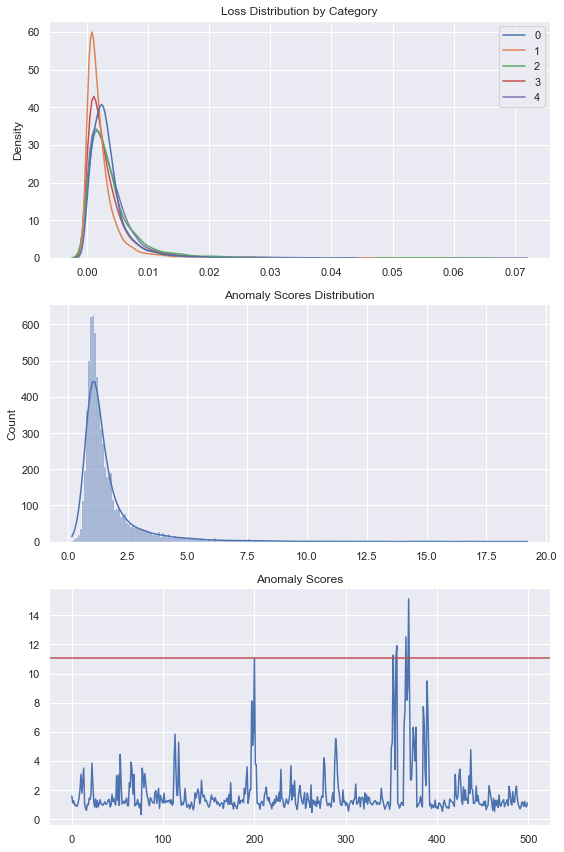

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,12))
sns.kdeplot(data=loss, log_scale=False, ax=ax1)
sns.histplot(data=scores, kde=True, log_scale=False, ax=ax2);
sns.lineplot(data=scores[:500], ax=ax3)
ax1.set_title('Loss Distribution by Category')
ax2.set_title('Anomaly Scores Distribution')
ax3.set_title('Anomaly Scores')
ax3.axhline(y=thresh, c='r')
plt.tight_layout();